In [1]:
#加载必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms


In [2]:
#定义超参数
BATCH_SIZE=16#每批处理的数据
DEVICE=torch.device("cuda"if torch.cuda.is_available()else"cpu")#用cpu还是gpu
EPOCHS=10#训练数据集的轮次

#构建pipline 对图像做处理
pipeline =transforms.Compose([
    transforms.ToTensor(),#将图片转换成tensor
    transforms.Normalize((0.1307,),(0.3081,))#正则化 降低模型复杂度
  ])

In [3]:
#下载、加载数据集
from torch.utils.data import DataLoader

#下载数据集
train_set=datasets.MNIST("data",train=True,download=True,transform=pipeline)
test_set=datasets.MNIST("data",train=False,download=True,transform=pipeline)
#加载数据
train_loader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)#shuffle是打乱的意思
test_loader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)


100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [4]:

#构建网络模型
class Digit(nn.Module):#继承Moudle类
    def __init__(self):
        super().__init__()
        self.convl=nn.Conv2d(1,10,5)#二维卷积  1：灰度图片的通道 10：输出通道 5：卷积核kernl
        self.conv2=nn.Conv2d(10,20,3)#10:输入通道20 ：输出通道 3：卷积核大小
        #全连接层  线性层
        self.fcl=nn.Linear(20*10*10,500)##20*10*10输入通道 500输出通道
        self.fc2=nn.Linear(500,10)#500输入通道  10输出通道
    def forward(self,x):
        input_size=x.size(0)#batch_size
        x=self.convl(x)  #输入：batch*1*28*28，输出：batch*10*24*24（28-5+1）
        x=F.relu(x)#保持shape不变 激活层
        x=F.max_pool2d(x,2,2)#池化层  对图片进行压缩   输入：batch*10*24*24
        #输出 batch*10*12*12
        x=self.conv2(x)#输入：batch*10*12*12  输出：batch*20*（12-3+1）-（12-3+1）
        x=F.relu(x)
        #拉伸
        x=x.view(input_size,-1)  #-1  自动计算维度20*10*10=2000
        #进入全连接层
        x=self.fcl(x)#输入：batch*2000  输出batch*500
        x=F.relu(x)
        x=self.fc2(x)#输入batch*500  输出：batch*10
        output=F.log_softmax(x,dim=1)#计算分类，每个数字的概率值
        return output


In [5]:
#定义优化器
model=Digit().to(DEVICE)
optimizer = optim.Adam(model.parameters())

In [8]:
#训练方法
def train_model(model,device,train_loader,optimizer,epoch):
    model.train()
    for batch_index,(data,target) in enumerate(train_loader):
        data,target=data.to(device),target.to(device)#部署到device上去
         #梯度初始化为0
        optimizer.zero_grad()
        #训练后的结果
        output=model(data)
        #计算损失
        loss=F.cross_entropy(output,target)#交叉熵损失函数
        #找到概率值最大的下标
        pred=output.max(1,keepdim=True)
        #反向传播
        loss.backward()
        #参数优化
        optimizer.step()
        if batch_index%3000==0:
            print("Train Epoch : {} \t Loss:{:.6f}".format(epoch,loss.item()))


In [6]:

#定义测试方法
def test_model(model,device,test_loader):
    #模拟验证
    model.eval()
    #正确率
    correct=0.0
    #测试损失
    test_loss=0.0
    with torch.no_grad():#不会计算梯度，也不会进行反向传播
        for data, target in test_loader:
            #部署到device上
            data,target=data.to(device),target.to(device)
            #测试数据
            output=model(data)
            #测试损失
            test_loss+=F.cross_entropy(output,target).item()
            #找到概率值最大的索引
            pred=output.max(1,keepdim=True)[1]#值 索引
            #另外两种方法 pred=torch.max(output,dim=1)
            #pred=output.argmax(dim=1)
            #累计正确的数目
            correct+=pred.eq(target.view_as(pred)).sum().item()
        test_loss/=len(test_loader.dataset)
        print("Test-Average loss:{:.4f},Accuracy:{:.3f}\n".format(test_loss,100.0*correct/len(test_loader.dataset)))


In [9]:
#调用方法
for epoch in range(1,EPOCHS+1):
    train_model(model,DEVICE,train_loader,optimizer,epoch)
    test_model(model,DEVICE,test_loader)


Train Epoch : 1 	 Loss:2.273204
Train Epoch : 1 	 Loss:0.007498
Test-Average loss:0.0022,Accuracy:98.865

Train Epoch : 2 	 Loss:0.229240
Train Epoch : 2 	 Loss:0.034277
Test-Average loss:0.0014,Accuracy:99.283

Train Epoch : 3 	 Loss:0.487745
Train Epoch : 3 	 Loss:0.131745
Test-Average loss:0.0009,Accuracy:99.552

Train Epoch : 4 	 Loss:0.094178
Train Epoch : 4 	 Loss:0.000857
Test-Average loss:0.0007,Accuracy:99.595

Train Epoch : 5 	 Loss:0.000009
Train Epoch : 5 	 Loss:0.001053
Test-Average loss:0.0006,Accuracy:99.685

Train Epoch : 6 	 Loss:0.000017
Train Epoch : 6 	 Loss:0.000058
Test-Average loss:0.0007,Accuracy:99.613

Train Epoch : 7 	 Loss:0.000001
Train Epoch : 7 	 Loss:0.000002
Test-Average loss:0.0005,Accuracy:99.757

Train Epoch : 8 	 Loss:0.000000
Train Epoch : 8 	 Loss:0.018663
Test-Average loss:0.0005,Accuracy:99.750

Train Epoch : 9 	 Loss:0.000000
Train Epoch : 9 	 Loss:0.000003
Test-Average loss:0.0004,Accuracy:99.800

Train Epoch : 10 	 Loss:0.000000
Train Epoch :

In [13]:
# 使用torchsummary查看模型的详细信息
from torchsummary import summary

model = Digit().to(DEVICE)
summary(model, (1, 28, 28))

print("\nModel Summary:")
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2           [-1, 20, 10, 10]           1,820
            Linear-3                  [-1, 500]       1,000,500
            Linear-4                   [-1, 10]           5,010
Total params: 1,007,590
Trainable params: 1,007,590
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 3.84
Estimated Total Size (MB): 3.91
----------------------------------------------------------------

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2           [-1, 20, 10, 10]           1,820
            Linear-3 

In [16]:
!pip install matplotlib

                                              0.0/7.6 MB ? eta -:--:--
                                              0.0/7.6 MB ? eta -:--:--
                                              0.0/7.6 MB ? eta -:--:--
                                              0.0/7.6 MB ? eta -:--:--
                                              0.0/7.6 MB ? eta -:--:--
                                              0.0/7.6 MB ? eta -:--:--
                                              0.0/7.6 MB 145.2 kB/s eta 0:00:53
                                              0.0/7.6 MB 145.2 kB/s eta 0:00:53
                                              0.0/7.6 MB 145.2 kB/s eta 0:00:53
                                              0.0/7.6 MB 145.2 kB/s eta 0:00:53
                                              0.0/7.6 MB 145.2 kB/s eta 0:00:53
                                              0.0/7.6 MB 145.2 kB/s eta 0:00:53
                                              0.0/7.6 MB 67.8 kB/s eta 0:01:53
               

     ---------------------------------------- 55.4/55.4 kB ? eta 0:00:00
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


Train Epoch : 1 	 Loss:2.301768
Train Epoch : 1 	 Loss:2.326348
Test-Average loss:0.1440,Accuracy:10.462

Train Epoch : 2 	 Loss:2.313683
Train Epoch : 2 	 Loss:2.268545
Test-Average loss:0.1440,Accuracy:10.462

Train Epoch : 3 	 Loss:2.300388
Train Epoch : 3 	 Loss:2.298934
Test-Average loss:0.1440,Accuracy:10.462

Train Epoch : 4 	 Loss:2.321507
Train Epoch : 4 	 Loss:2.307609
Test-Average loss:0.1440,Accuracy:10.462

Train Epoch : 5 	 Loss:2.302961
Train Epoch : 5 	 Loss:2.309669
Test-Average loss:0.1440,Accuracy:10.462

Train Epoch : 6 	 Loss:2.275454
Train Epoch : 6 	 Loss:2.279120
Test-Average loss:0.1440,Accuracy:10.462

Train Epoch : 7 	 Loss:2.325217
Train Epoch : 7 	 Loss:2.340153
Test-Average loss:0.1440,Accuracy:10.462

Train Epoch : 8 	 Loss:2.299585
Train Epoch : 8 	 Loss:2.275224
Test-Average loss:0.1440,Accuracy:10.462

Train Epoch : 9 	 Loss:2.250669
Train Epoch : 9 	 Loss:2.303938
Test-Average loss:0.1440,Accuracy:10.462

Train Epoch : 10 	 Loss:2.307553
Train Epoch :

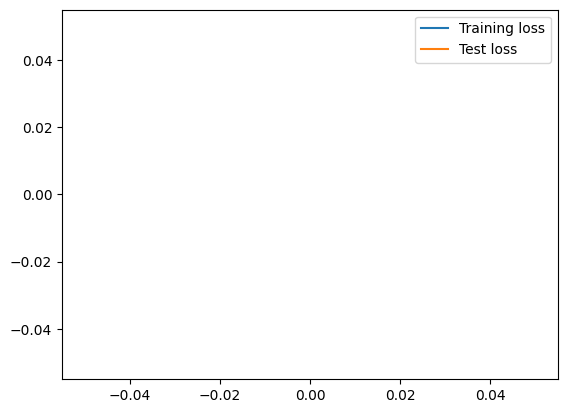

In [17]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []

for epoch in range(1, EPOCHS+1):
    train_loss = train_model(model, DEVICE, train_loader, optimizer, epoch)
    test_loss = test_model(model, DEVICE, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()
